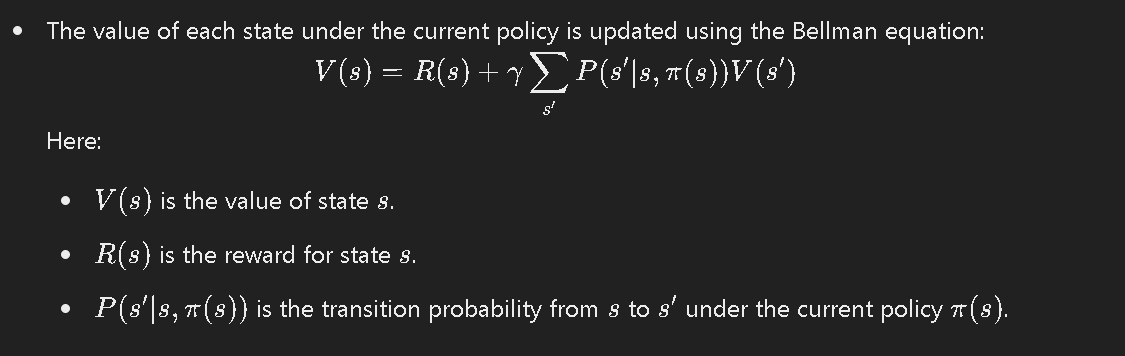

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid world setup and transition model
def create_grid_world(r):
    # Reward function for the grid world
    rewards = np.full(9, -1)  # Default reward of -1 for all states
    rewards[0] = r  # Terminal state at the upper-left corner
    rewards[2] = 10  # Terminal state at the upper-right corner

    # Transition model
    transitions = np.zeros((9, 4, 9))  # 9 states, 4 actions (Up, Down, Left, Right)

    # Directions: Up = 0, Down = 1, Left = 2, Right = 3
    directions = [(-3, 0), (3, 0), (0, -1), (0, 1)]  # (row, column) offsets
    for state in range(9):
        if state in [0, 2]:  # Skip terminal states
            continue
        for action in range(4):
            intended_direction = directions[action]
            intended_state = state + intended_direction[0] + intended_direction[1]

            # Check for boundary conditions (stay in place if invalid)
            if intended_state < 0 or intended_state >= 9:
                intended_state = state

            # 80% probability to go in the intended direction
            transitions[state, action, intended_state] += 0.8

            # 10% probability for each perpendicular direction
            for perp_action in [(action + 1) % 4, (action + 3) % 4]:
                perp_direction = directions[perp_action]
                perp_state = state + perp_direction[0] + perp_direction[1]

                # Check for boundary conditions
                if perp_state < 0 or perp_state >= 9:
                    perp_state = state

                transitions[state, action, perp_state] += 0.1

    return rewards, transitions

# Create the grid world and get the rewards and transitions
reward_value = 10  # Set the reward for terminal state
rewards, transitions = create_grid_world(reward_value)

# Print the state transition matrix with new state information
for state in range(9):
    if state in [0, 2]:  # Skip terminal states
        continue
    print(f"State {state}:")
    for action in range(4):
        print(f"  Action {action} (Up=0, Down=1, Left=2, Right=3):")
        for new_state in range(9):
            prob = transitions[state, action, new_state]
            if prob > 0:  # Only print non-zero probabilities
                print(f"    To State {new_state}: Probability = {prob}")


State 1:
  Action 0 (Up=0, Down=1, Left=2, Right=3):
    To State 1: Probability = 0.8
    To State 2: Probability = 0.1
    To State 4: Probability = 0.1
  Action 1 (Up=0, Down=1, Left=2, Right=3):
    To State 0: Probability = 0.1
    To State 1: Probability = 0.1
    To State 4: Probability = 0.8
  Action 2 (Up=0, Down=1, Left=2, Right=3):
    To State 0: Probability = 0.8
    To State 2: Probability = 0.1
    To State 4: Probability = 0.1
  Action 3 (Up=0, Down=1, Left=2, Right=3):
    To State 0: Probability = 0.1
    To State 1: Probability = 0.1
    To State 2: Probability = 0.8
State 3:
  Action 0 (Up=0, Down=1, Left=2, Right=3):
    To State 0: Probability = 0.8
    To State 4: Probability = 0.1
    To State 6: Probability = 0.1
  Action 1 (Up=0, Down=1, Left=2, Right=3):
    To State 0: Probability = 0.1
    To State 2: Probability = 0.1
    To State 6: Probability = 0.8
  Action 2 (Up=0, Down=1, Left=2, Right=3):
    To State 2: Probability = 0.8
    To State 4: Probability 

## Policy Iteration


Epoch 1:
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Values Grid:
100.00 88.47 10.00
96.78 93.69 91.28
93.96 90.98 88.60


Epoch 2:
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97


Final Policy:
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Final Values:
Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97



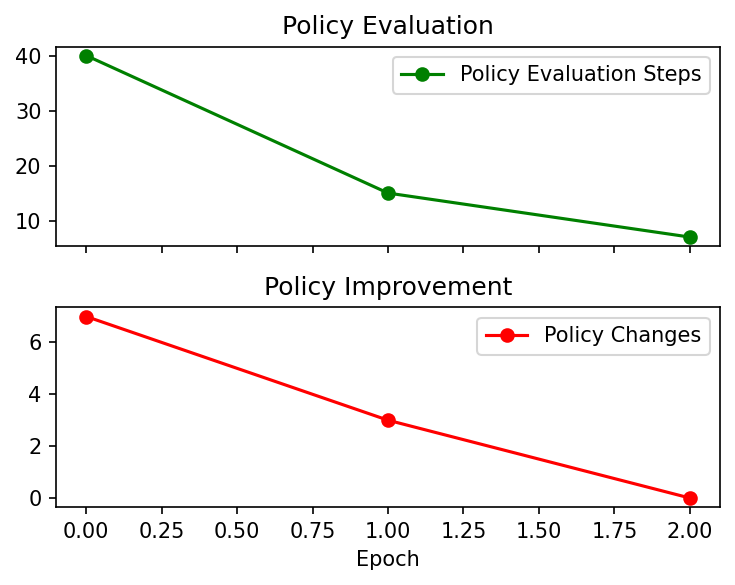


Epoch 1:
Policy Grid:
T → T
← → ↑
↑ → ↑

Values Grid:
3.00 8.01 10.00
8.28 6.93 8.28
6.78 5.61 6.93


Epoch 2:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.84 5.88 6.93


Epoch 3:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93


Final Policy:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Final Values:
Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93



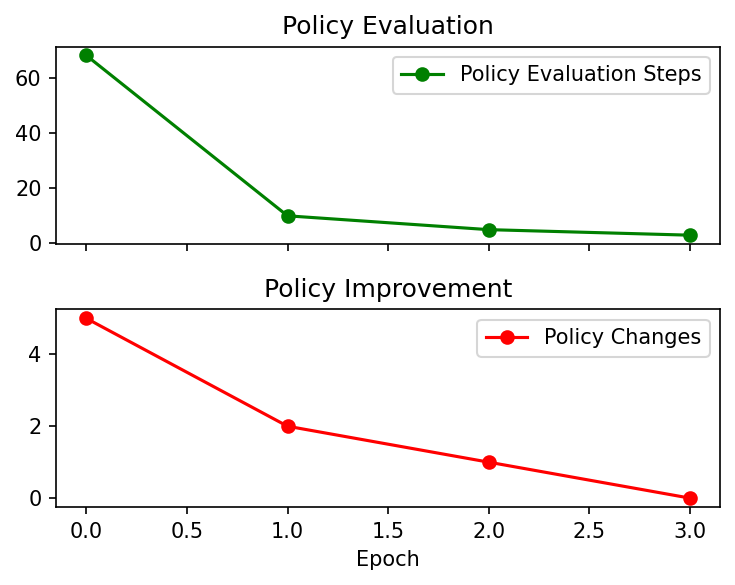


Epoch 1:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.78 5.61 6.93


Epoch 2:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93


Final Policy:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Final Values:
Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93



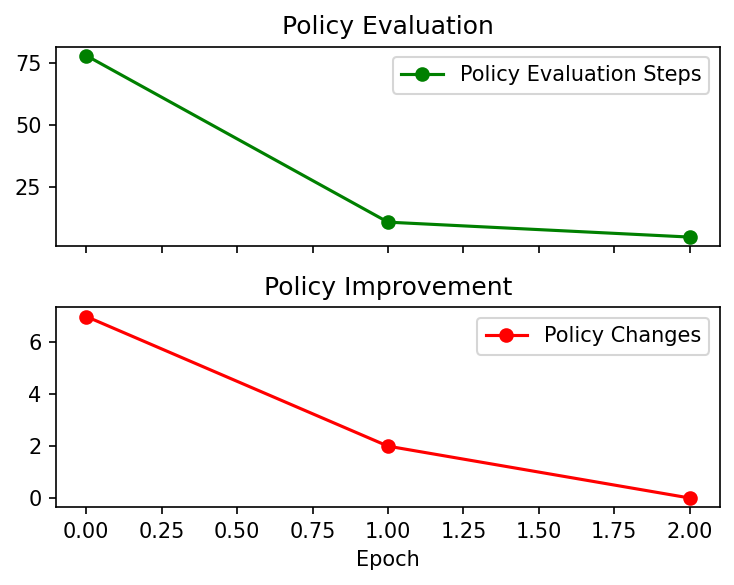


Epoch 1:
Policy Grid:
T → T
← → ↑
↑ → ↑

Values Grid:
-3.00 7.35 10.00
8.28 6.95 8.28
6.80 5.76 6.93


Epoch 2:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.87 6.93


Epoch 3:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93


Final Policy:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Final Values:
Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93



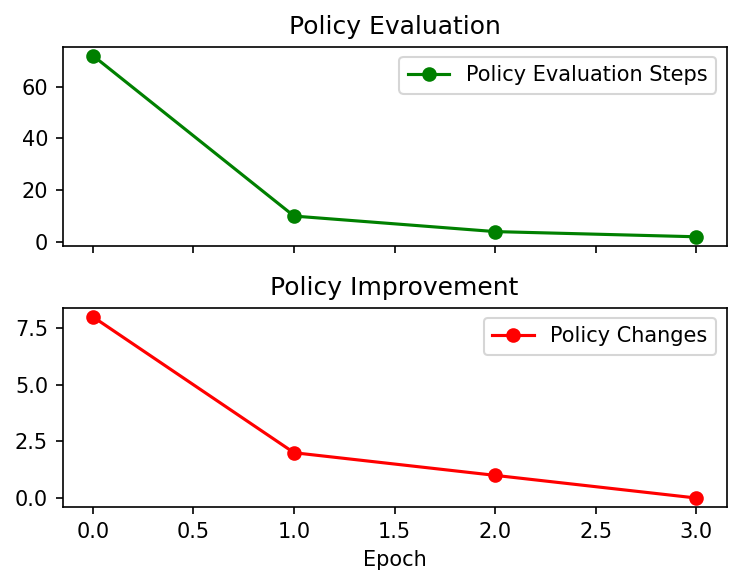

In [38]:


class PolicyIteration:
    def __init__(self, rewards, transitions, gamma, init_policy=None):
        self.num_states = len(rewards)
        self.num_actions = len(transitions[0])  # Number of actions
        self.rewards = np.nan_to_num(rewards)
        self.transitions = transitions
        self.gamma = gamma

        self.values = np.zeros(self.num_states)
        self.policy = (
            np.random.randint(0, self.num_actions, self.num_states)
            if init_policy is None
            else init_policy
        )

    def compute_delta(self):
        """
        compute the value function for the current policy using the Bellman equation
        
        """
        delta = 0
        for state in range(self.num_states):
            old_value = self.values[state]
            action = self.policy[state]
            probs = self.transitions[state, action]
            self.values[state] = self.rewards[state] + self.gamma * np.sum(probs * self.values)
            delta = max(delta, abs(old_value - self.values[state]))
        return delta

    def policy_evaluation(self, tol=1e-3):
        epochs = 0
        while epochs <100:
            delta = self.compute_delta()
            if delta < tol:
                break
            epochs += 1
        return epochs

    def policy_improvement(self):
        changes = 0
        for state in range(self.num_states):
            old_action = self.policy[state]
            action_values = np.zeros(self.num_actions)
            for action in range(self.num_actions):
                probs = self.transitions[state, action]
                action_values[action] = np.sum(probs * self.values)
            self.policy[state] = np.argmax(action_values)
            if self.policy[state] != old_action: ##to keep track of how many times the policy changed
                changes += 1
        return changes

    def train(self, tol=1e-3, plot=True):
        epoch = 0
        eval_epochs = self.policy_evaluation(tol)
        eval_history = [eval_epochs]
        policy_changes = self.policy_improvement()
        change_history = [policy_changes]

        while policy_changes > 0 and epoch < 500:
            epoch += 1
            eval_epochs = self.policy_evaluation(tol)
            eval_history.append(eval_epochs)
            policy_changes = self.policy_improvement()
            change_history.append(policy_changes)

            print(f"\nEpoch {epoch}:")
            self.print_grid(self.policy, "Policy")
            self.print_grid(self.values, "Values")

        print("\nFinal Policy:")
        self.print_grid(self.policy, "Policy")
        print("Final Values:")
        self.print_grid(self.values, "Values")

        if plot:
            self.plot_convergence(eval_history, change_history)

    def plot_convergence(self, eval_history, change_history):
        fig, axes = plt.subplots(2, 1, figsize=(5, 4), dpi=150, sharex=True)

        axes[0].plot(eval_history, marker='o', label='Policy Evaluation Steps', color='green')
        axes[0].set_title("Policy Evaluation")
        axes[0].legend()

        axes[1].plot(change_history, marker='o', label='Policy Changes', color='red')
        axes[1].set_title("Policy Improvement")
        axes[1].set_xlabel("Epoch")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def print_grid(self, data, title=""):
        grid_size = 3
        arrows = ['↑', '↓', '←', '→']
        print(f"{title} Grid:")
        for i in range(grid_size):
            row = []
            for j in range(grid_size):
                idx = i * grid_size + j
                if data is self.policy:
                    row.append('T' if idx in [0, 2] else arrows[data[idx]])
                elif data is self.values:
                    row.append(f"{data[idx]:.2f}")
            print(' '.join(row))
        print()


# Example usage
reward_values = [100, 3, 0, -3]
for r in reward_values:
    rewards, transitions = create_grid_world(r)
    pi = PolicyIteration(rewards, transitions, gamma=0.99)
    pi.train()


## Value Iteration

Converged after 14 iterations.
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97



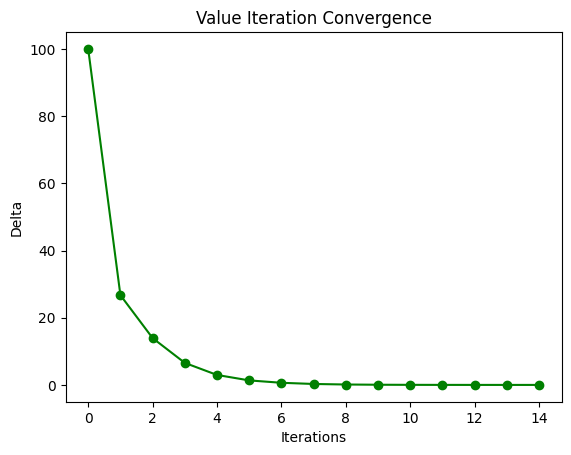

Converged after 10 iterations.
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93



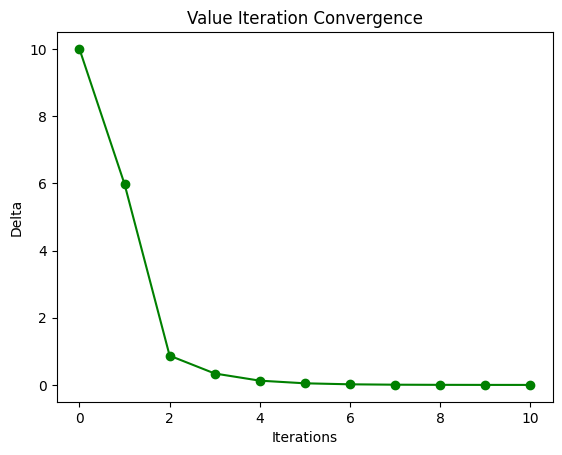

Converged after 10 iterations.
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93



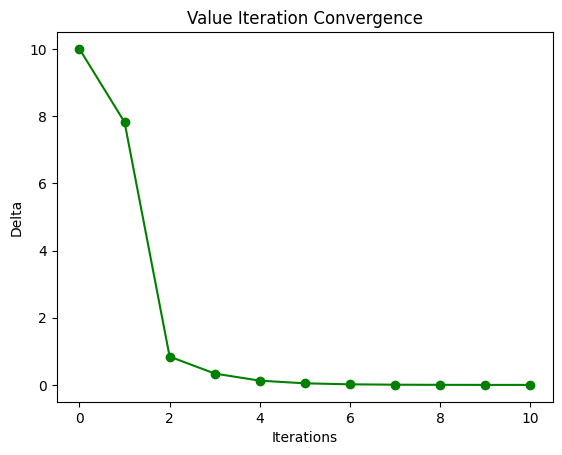

Converged after 10 iterations.
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93



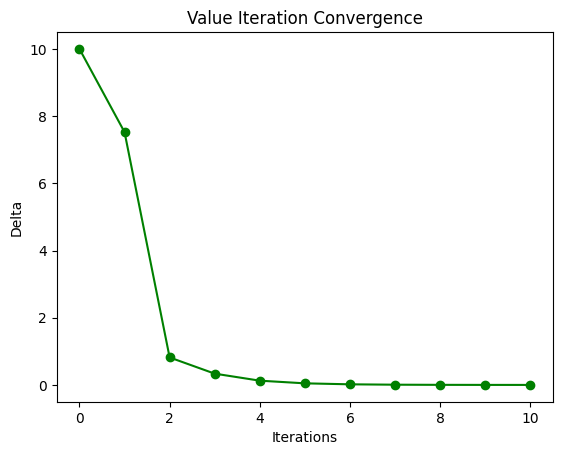

In [37]:
class ValueIteration:
    def __init__(self, rewards, transitions, gamma, tol=1e-3):
        self.num_states = len(rewards)
        self.num_actions = len(transitions[0])  # Number of actions
        self.rewards = np.nan_to_num(rewards)
        self.transitions = transitions
        self.gamma = gamma
        self.tol = tol
        
        self.values = np.zeros(self.num_states)
        self.policy = np.zeros(self.num_states, dtype=int)  # Initialize random policy

    def compute_delta(self):
        """Compute the value function for the current policy using the Bellman equation."""
        delta = 0
        for state in range(self.num_states):
            old_value = self.values[state]
            action_values = np.zeros(self.num_actions)
            for action in range(self.num_actions):
                probs = self.transitions[state, action]
                action_values[action] = self.rewards[state] + self.gamma * np.sum(probs * self.values)
            self.values[state] = np.max(action_values)  # Max over all actions
            delta = max(delta, abs(old_value - self.values[state]))
        return delta

    def train(self, max_epochs=500, plot=True):
        epoch = 0
        delta = self.compute_delta()
        delta_history = [delta]

        while delta > self.tol and epoch < max_epochs:
            epoch += 1
            delta = self.compute_delta()
            delta_history.append(delta)
        
        self.policy = self.get_policy()  # Extract the policy after value function converges

        print(f"Converged after {epoch} iterations.")
        self.print_grid(self.policy, "Policy")
        self.print_grid(self.values, "Values")

        if plot:
            self.plot_convergence(delta_history)

    def get_policy(self):
        """Extract the policy based on the current values."""
        pi = np.zeros(self.num_states, dtype=int)
        for state in range(self.num_states):
            action_values = np.zeros(self.num_actions)
            for action in range(self.num_actions):
                probs = self.transitions[state, action]
                action_values[action] = self.rewards[state] + self.gamma * np.sum(probs * self.values)
            pi[state] = np.argmax(action_values)  # Choose action with maximum value
        return pi

    def plot_convergence(self, delta_history):
        """Plot the convergence of the value function."""
        plt.plot(delta_history, marker='o', color='green')
        plt.xlabel("Iterations")
        plt.ylabel("Delta")
        plt.title("Value Iteration Convergence")
        plt.show()

    def print_grid(self, data, title=""):
        """Print the results in a grid format."""
        grid_size = 3  # Assuming a 3x3 grid
        arrows = ['↑', '↓', '←', '→']
        print(f"{title} Grid:")
        for i in range(grid_size):
            row = []
            for j in range(grid_size):
                idx = i * grid_size + j
                if data is self.policy:
                    row.append('T' if idx in [0, 2] else arrows[data[idx]])
                elif data is self.values:
                    row.append(f"{data[idx]:.2f}")
            print(' '.join(row))
        print()


# Example usage
reward_values = [100, 3, 0, -3]
for r in reward_values:
    rewards, transitions = create_grid_world(r)
    vi = ValueIteration(rewards, transitions, gamma=0.99)
    vi.train()
